In [1]:
print('kernel live')

kernel live


# load data and libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from bootstrap_tools import *

pd.options.mode.chained_assignment = None

In [118]:
by = 'by_text' # by_text or as_single_text or by_source
gap = 24; gap=str(gap) # 0 or 24. units are hours
sim_type = 'BC' # BC or cosine or SWF
resampling = '_r1'
control = '' #'_control'

all_parties = pd.read_parquet('./data/results_'+by+'__'+gap+'hr_'+sim_type+resampling+control+'.parquet')
con = pd.read_parquet('./data/results_'+by+'_Con_'+gap+'hr_'+sim_type+resampling+control+'.parquet')
lab = pd.read_parquet('./data/results_'+by+'_Lab_'+gap+'hr_'+sim_type+resampling+control+'.parquet')

con['responding_party'] = 'Con'
lab['responding_party'] = 'Lab'
all_parties['responding_party'] = 'All'

df = pd.concat([all_parties, con, lab]).reset_index(drop=True)

In [119]:
#drop any all-null columns
df = df[[col for col in df.columns if not all(df.sample(10000)[col].isna())]]

In [120]:
df['text_type'].value_counts()

url               444297
tweet             399018
commons_speech    353742
Name: text_type, dtype: int64

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197057 entries, 0 to 1197056
Data columns (total 41 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   mp_name                    752760 non-null   object        
 1   text_id                    1197057 non-null  object        
 2   time                       1197057 non-null  datetime64[ns]
 3   user_id                    399018 non-null   object        
 4   n_likes                    399018 non-null   float64       
 5   n_replies                  399018 non-null   float64       
 6   n_retweets                 399018 non-null   float64       
 7   n_quotes                   399018 non-null   float64       
 8   party                      533256 non-null   object        
 9   text_type                  1197057 non-null  object        
 10  constituency               169308 non-null   object        
 11  job                        119490 non

# identify top correlates

In [122]:
import statsmodels.api as sm

In [123]:
correlates_of_cause = {'tweet':['n_likes','n_replies','n_retweets','n_quotes'],
                       'url':['sum_views','sum_clicks','sum_shares','sum_likes',
                              'sum_loves',
                              'sum_hahas','sum_wows','sum_sorrys',
                              'sum_angers','sum_comments','sum_share_without_clicks',
                             ],
                      }

def append_log_features(df, features):
    for feature in features:
        if feature!='newsguard_score':
            df[feature+'_log'] = np.log(df[feature].replace(0,0.1))
    return df
        
def identify_top_linear_correlates(df, cause_type, response_type, log_features, linear_features):
    response_col = response_type+'_sim_delta'
    correlates = correlates_of_cause[cause_type]
    
    if log_features:
        df = append_log_features(df, correlates)
        if linear_features:
            correlates = correlates + [x+'_log' for x in correlates if x!='newsguard_score']
        else: 
            correlates = [x+'_log' if x!='newsguard_score' else 'newsguard_score' for x in correlates]        
    
    df = df[df['text_type']==cause_type]
    df = df.dropna(subset = correlates+[response_col]).reset_index(drop=True)
    df['const'] = 1
    y = df[response_col]
    X = df[correlates+['const']]
    
    results = sm.OLS(y, X).fit()
    
    return results

def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"p":pvals,
                               "coeff":coeff,
                               "CI_lower":conf_lower,
                               "CI_upper":conf_higher
                                })

    #Reordering...
    results_df = results_df[['p','coeff','CI_lower','CI_upper']]
    return results_df

In [124]:
causes = ['tweet','url']
responses = ['commons_speech', 'tweet']
parties = ['All','Lab','Con']
log_features= True
lin_features = False
master_table = list()

for party in parties:
    for cause in causes:
        for response in responses:
            print(cause, 'on', response)
            df1 = df[df['responding_party']==party]
            results = identify_top_linear_correlates(df1, cause, response, log_features, lin_features)
            results = results_summary_to_dataframe(results).sort_values('p').drop('const')
            results = results.reset_index().rename(columns = {'index':'correlate'})
            results['cause'] = cause
            results['response'] = response
            results['responding_party'] = party
            master_table.append(results)
        
master_table = pd.concat(master_table)
master_table = master_table[['responding_party','cause','response','correlate','p','coeff']].reset_index(drop=True)

tweet on commons_speech
tweet on tweet
url on commons_speech


/home/jmbollen/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


url on tweet


/home/jmbollen/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


tweet on commons_speech
tweet on tweet
url on commons_speech


/home/jmbollen/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


url on tweet


/home/jmbollen/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


tweet on commons_speech
tweet on tweet
url on commons_speech


/home/jmbollen/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


url on tweet


/home/jmbollen/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [125]:
n_exps = master_table[['responding_party','cause','response']].nunique().product() #number of separate regressions
master_table['p_bon'] = master_table['p']*n_exps
table = master_table[master_table['p_bon']<0.05].drop(columns = ['p_bon'])

In [126]:
table['cause'] = table['cause'].map({'url':'News Article on FB', 
                    'tweet':'MP Tweet',
                    'commons_speech':'Commons Q&A'})
table['response'] = table['response'].map({'url':'News Article on FB', 
                    'tweet':'MP Tweet',
                    'commons_speech':'Commons Q&A'})
table['correlate'] = table['correlate'].apply(lambda x: x.replace('sum','n'))

table = table.rename(columns={'responding_party':'Party','cause':'Stimulus','response':'Response'})
table = table.set_index(['Party','Stimulus','Response'])

KeyError: 'cause'

In [ ]:
table

In [ ]:
print(table[['correlate', 'coeff','p']].to_latex(float_format="%.2g"))
print('\n\n')

# correlation and monotonicity tests

In [111]:
# #spearmans rho correlation test
# from scipy.stats import spearmanr
# from scipy.stats import pearsonr

In [112]:
# causes = ['url','tweet']
# responses = ['commons_speech', 'tweet']
# correlates_of_cause = {'tweet':['n_likes','n_replies','n_retweets','n_quotes'],
#                        'url':['sum_views','sum_clicks','sum_shares','sum_likes',
#                               'sum_loves','sum_hahas','sum_wows','sum_sorrys',
#                               'sum_angers','sum_comments','sum_share_without_clicks',
#                               'newsguard_score'],
#                        'commons_speech':['mp_name','constituency','party','job'],} 


# results = list()
# for cause in causes:
#     for response in responses:
#         for corr in correlates_of_cause[cause]:
#             df2 = df[df['text_type']==cause]
#             df2 = df2.dropna(subset=[response+'_sim_delta', corr])
#             df2 = df2[(df2[corr] > df2[corr].quantile(0.05)) & (df2[corr] < df2[corr].quantile(1))]

#             result = spearmanr(a=np.array(df2[corr]), b=np.array(df2[response+'_sim_delta']))
#             R_spearman = result.correlation
#             p_spearman = result.pvalue
#             R_pearson, p_pearson = pearsonr(np.array(df2[corr]), np.array(df2[response+'_sim_delta']))
        
#             results.append((cause, response, corr, R_pearson, p_pearson, R_spearman, p_spearman, ))

            
# results = pd.DataFrame(results, columns = ['cause','response','correlate', 'R_pearson','p_pearson',
#                                            'R_spearman','p_spearman'])
# results

# Overall mean effects 

slow. bootstraps over whole dataset 10000 times for each inference

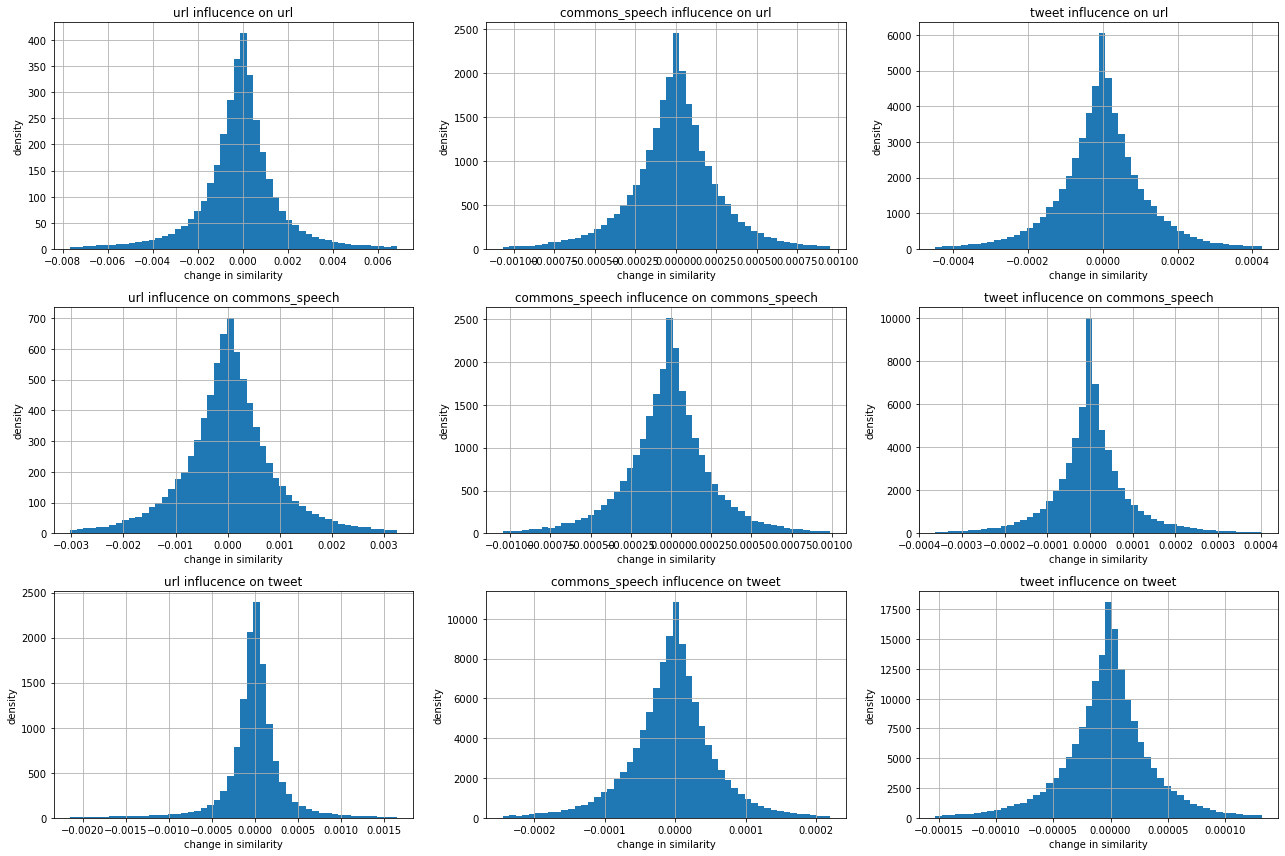

In [113]:
causes = ['url', 'commons_speech', 'tweet']
responses = ['url','commons_speech', 'tweet'] if 'url_sim_delta' in df.columns else ['commons_speech', 'tweet']


plt.rcParams["figure.figsize"] = (6*len(causes),4*len(responses))
fig, axs = plt.subplots(nrows = len(responses), ncols = len(causes))
for i, cause_type in enumerate(causes):
    for j, response_type in enumerate(responses):
        ax = axs[j,i]
        a = df[df['text_type']==cause_type].copy()
        a = a[a['responding_party'] == 'All']
        bins = np.linspace(a[response_type+'_sim_delta'].quantile(0.01), 
                           a[response_type+'_sim_delta'].quantile(0.99), 
                           51)
        a[response_type+'_sim_delta'].hist(bins = bins, ax=ax, density=True)
        ax.set_title(cause_type+' influcence on '+response_type)
        ax.set_xlabel('change in similarity')
        ax.set_ylabel('density')
        
fig.tight_layout()
fig.show()

In [114]:
causes = ['url', 'commons_speech', 'tweet']
responses = ['commons_speech', 'tweet'] #['url', 'commons_speech', 'tweet']
parties = ['All','Lab','Con']

table = list()

for party in parties:
    for i, cause_type in enumerate(causes):
        for j, response_type in enumerate(responses):
            a = df[df['text_type']==cause_type].copy()
            a = a[a['responding_party'] == party]
            y = a[response_type+'_sim_delta']
            diffs_of_means = mean_bootstrap(y, 100);
            if diffs_of_means.mean()>0:  p = ((diffs_of_means<=0).sum()+1)/(diffs_of_means.count()+1) 
            else: p = ((diffs_of_means>=0).sum()+1)/(diffs_of_means.count()+1)
            table.append((party, cause_type, response_type, diffs_of_means.mean(), 
                          diffs_of_means.quantile(0.025), diffs_of_means.quantile(0.975), p))
            

table = pd.DataFrame(table,columns=['responding_party','cause','response','mean','95%CI_lower','95%CI_upper', 'p'])
table['95%CI_pm'] = table.apply(lambda x: max(x['mean']-x['95%CI_lower'], x['95%CI_upper']-x['mean']) ,axis=1)
table['95%CI_assym'] = table.apply(lambda x: (x['95%CI_upper']-x['mean']) - (x['mean']-x['95%CI_lower']) ,axis=1)



In [115]:
table['cause'] = table['cause'].map({'url':'News Article on FB', 
                    'tweet':'MP Tweet',
                    'commons_speech':'Commons Q&A'})
table['response'] = table['response'].map({'url':'News Article on FB', 
                    'tweet':'MP Tweet',
                    'commons_speech':'Commons Q&A'})

table = table.rename(columns={'responding_party':'Party','cause':'Stimulus','response':'Response'})
# table = table[table['Response']!='News Article on FB'] #drop news article responses. undefined. 
table = table.set_index(['Party','Stimulus','Response'])
table = table[['mean','95%CI_pm','p']]

In [116]:
table

mean      95%CI_pm         p
Party Stimulus           Response                                         
All   News Article on FB Commons Q&A  3.325251e-05  6.720082e-06  0.009901
                         MP Tweet    -1.846589e-05  3.081038e-06  0.009901
      Commons Q&A        Commons Q&A -1.681792e-05  2.663444e-06  0.009901
                         MP Tweet    -4.497737e-06  5.729385e-07  0.009901
      MP Tweet           Commons Q&A  3.258281e-06  1.014241e-06  0.009901
                         MP Tweet    -3.133287e-06  2.453162e-07  0.009901
Lab   News Article on FB Commons Q&A  1.038936e-04  8.214251e-06  0.009901
                         MP Tweet    -9.199804e-06  4.566596e-06  0.009901
      Commons Q&A        Commons Q&A -6.458393e-06  3.171121e-06  0.009901
                         MP Tweet    -6.392470e-06  6.126169e-07  0.009901
      MP Tweet           Commons Q&A  8.877404e-06  1.476560e-06  0.009901
                         MP Tweet    -3.815477e-06  3.732408e-07  0.009901
Con   News Article on FB Commons Q&A -1.075411e-05  6.862423e-06  0.009901
                         MP Tweet    -1.002021e-05  6.207045e-06  0.009901
      Commons Q&A        Commons Q&A  3.344104e-06  3.401129e-06  0.009901
                         MP Tweet    -9.550048e-07  9.451596e-07  0.039604
      MP Tweet           Commons Q&A  4.296307e-06  1.197353e-06  0.009901
                         MP Tweet    -2.219918e-06  4.721170e-07  0.009901

In [117]:
print(table.to_latex(
            header = ['Mean','+/-','p'],
            formatters = {'mean': (lambda x: '{x:.3g}'.format(x=x)),
                          '95%CI_pm' : (lambda x: '{x:.1g}'.format(x=x)),
                          'p' : (lambda x: '{x:.2g}'.format(x=x))}    
#             index = False,
))

\begin{tabular}{lllrrr}
\toprule
    &          &          &      Mean &   +/- &      p \\
Party & Stimulus & Response &           &       &        \\
\midrule
All & News Article on FB & Commons Q\&A &  3.33e-05 & 7e-06 & 0.0099 \\
    &          & MP Tweet & -1.85e-05 & 3e-06 & 0.0099 \\
    & Commons Q\&A & Commons Q\&A & -1.68e-05 & 3e-06 & 0.0099 \\
    &          & MP Tweet &  -4.5e-06 & 6e-07 & 0.0099 \\
    & MP Tweet & Commons Q\&A &  3.26e-06 & 1e-06 & 0.0099 \\
    &          & MP Tweet & -3.13e-06 & 2e-07 & 0.0099 \\
Lab & News Article on FB & Commons Q\&A &  0.000104 & 8e-06 & 0.0099 \\
    &          & MP Tweet &  -9.2e-06 & 5e-06 & 0.0099 \\
    & Commons Q\&A & Commons Q\&A & -6.46e-06 & 3e-06 & 0.0099 \\
    &          & MP Tweet & -6.39e-06 & 6e-07 & 0.0099 \\
    & MP Tweet & Commons Q\&A &  8.88e-06 & 1e-06 & 0.0099 \\
    &          & MP Tweet & -3.82e-06 & 4e-07 & 0.0099 \\
Con & News Article on FB & Commons Q\&A & -1.08e-05 & 7e-06 & 0.0099 \\
    &          & MP 